In [2]:
import numpy as np
import scipy
from scipy.misc import imread
import matplotlib.pyplot as plt 
%matplotlib inline

img has shape (190, 332, 3)
conv: I.shape=(190, 332), F.shape=(3, 3)
conv: I.shape=(190, 332), F.shape=(3, 3)
conv: I.shape=(190, 332), F.shape=(3, 3)
conv: I.shape=(190, 332), F.shape=(3, 3)
conv: I.shape=(190, 332), F.shape=(3, 3)
conv: I.shape=(190, 332), F.shape=(3, 3)


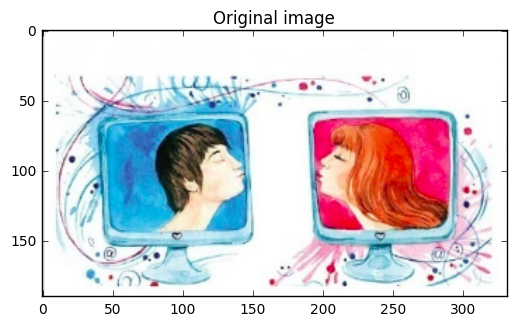

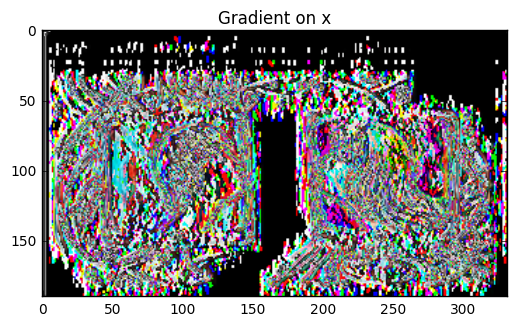

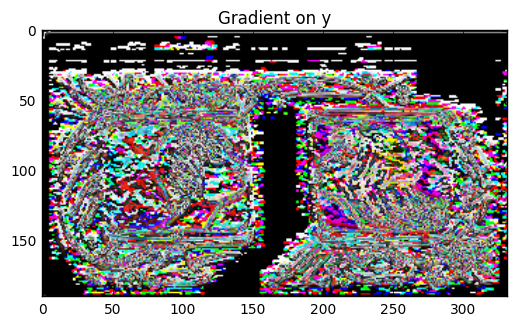

In [18]:
def mult(A, B, size):
    #print ("mult: A.shape={}, B.shape={}".format(A.shape, B.shape))
    A = A.reshape([size])
    B = B.reshape([size])
    ans = sum([A[i] * B[i] for i in range(size)])
    return ans
    
def conv(I, F):
    '''F: 3x3 filter, I: nxm image (n, m >= 3)
    Return: nF: nxm image, after filtering. Edges are padded
    '''
    print ("conv: I.shape={}, F.shape={}".format(I.shape, F.shape))
    n, m = I.shape
    padded_I = np.zeros([n+2, m+2])
    for i in range(n):
        for j in range(m):
            padded_I[i+1,j+1] = I[i,j]
    res = np.zeros([n, m])
    cnt = 0
    for i in range(n):
        for j in range(m):
            cnt += 1
            if (cnt % 1000000 == 0):
                print ("Done {} convs".format(cnt))
            res[i,j] = mult(F, padded_I[i:i+3, j:j+3], 9)
    return res

def convjpg(I, F):
    # conv on each of the channels of F
    #print ("convjpg: I.shape={}, F.shape={}".format(I.shape, F.shape))
    res = np.zeros(I.shape)
    for i in range(I.shape[-1]):
        res[:,:,i] = conv(I[:,:,i], F)
    return res
            
def sobelFilter():
    fname = "data/1.png"
    img = imread(fname)
    plt.figure()
    plt.imshow(img)
    plt.title("Original image")
    print ("img has shape {}".format(img.shape))
    
    Dx = np.array([[1,0,-1], [2,0,-2], [1,0,-1]])
    Dy = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
    dximg = convjpg(img, Dx)
    dyimg = convjpg(img, Dy)
    plt.figure()
    plt.imshow(dximg)
    plt.title("Gradient on x")
    plt.figure()
    plt.imshow(dyimg)
    plt.title("Gradient on y")
    
sobelFilter()

In [33]:
def mult(A, B, size):
    #print ("mult: A.shape={}, B.shape={}".format(A.shape, B.shape))
    A = A.reshape([size])
    B = B.reshape([size])
    ans = sum([A[i] * B[i] for i in range(size)])
    return ans
    
def conv(I, F):
    '''F: 3x3 filter, I: nxm image (n, m >= 3)
    Return: nF: nxm image, after filtering. Edges are padded
    '''
    #print ("conv: I.shape={}, F.shape={}".format(I.shape, F.shape))
    n, m = I.shape
    padded_I = np.zeros([n+2, m+2])
    for i in range(n):
        for j in range(m):
            padded_I[i+1,j+1] = I[i,j]
    res = np.zeros([n, m])
    cnt = 0
    for i in range(n):
        for j in range(m):
            cnt += 1
            if (cnt % 1000000 == 0):
                print ("Done {} convs".format(cnt))
            res[i,j] = mult(F, padded_I[i:i+3, j:j+3], 9)
    return res

def img2grayscale(img):
    
    new_image = np.zeros([img.shape[0],img.shape[1]])
    for i in range(new_image.shape[0]):
        for j in range(new_image.shape[1]):
            new_image[i,j] = 0.2126 * img[i,j,0] + 0.7152 * img[i,j,1] + 0.0722 * img[i,j,2]
    return new_image
        
def calculate_energy(img):
    Dx = np.array([[1,0,-1], [2,0,-2], [1,0,-1]])
    Dy = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
    imgdx = np.absolute(conv(img, Dx))
    imgdy = np.absolute(conv(img, Dy))
    return imgdx + imgdy

def remove_vertical_seam(img_gs, x_ids):
    nrows = img_gs.shape[0]
    ncols = img_gs.shape[1]
    new_img = np.zeros([nrows, ncols-1])
    for i in range(nrows):
        for j in range(ncols-1):
            if (j < x_ids[i]):
                new_img[i,j] = img_gs[i,j]
            elif (j >= x_ids[i]):
                new_img[i,j] = img_gs[i,j+1]
    return new_img

def print_before_cutting(img_gs, x_ids, title):
    plt.figure()
    plt.title(title)
    plt.imshow(img_gs, cmap="gray", alpha=0.5)
    n = img_gs.shape[0]
    m = img_gs.shape[1]
    overlay = np.ones([n, m, 3])
    for row in range(img_gs.shape[0]):
        #print ("print_before_cutting: row={}".format(row))
        #print ("x_ids[row]={}".format(x_ids[row]))
        overlay[row, x_ids[row], 1] = 0
        overlay[row, x_ids[row], 2] = 0 
    plt.imshow(overlay, alpha=0.4)
    
    
def seam_carving(fname, start_x):

    img = imread(fname)
    plt.figure()
    plt.imshow(img)
    plt.title("Original image")
    print ("img has shape {}".format(img.shape))
    img_gs = img2grayscale(img)
    plt.figure()
    plt.imshow(img_gs, cmap="gray")
    plt.title("Grayscale image")
    
    for cnt in range(80):
        #print ("img_gs.shape={}".format(img_gs.shape))
        # Remove the seam with minimum cumulated energy
        img_energy = calculate_energy(img_gs)
       
        M = np.zeros(img_gs.shape)
        C = np.zeros(img_gs.shape)
        for i in range(1, img_gs.shape[0]):
            for j in range(img_gs.shape[1]):
                C[i,j] = j
                min_prev = M[i-1,j]
                if (j > 0 and M[i-1, j-1] < min_prev):
                    min_prev = M[i-1, j-1]
                    C[i,j] = j-1
                if (j < img_gs.shape[1]-1 and M[i-1, j+1] < min_prev):
                    min_prev = M[i-1, j+1]
                    C[i,j] = j+1
                M[i, j] = min_prev + img_energy[i,j]
        
        #x = np.argmin(M[img_gs.shape[0]-1, :])
        x = start_x
        
        x_ids = [int(x)] * img_gs.shape[0]
        for i in range(img_gs.shape[0]-1, -1, -1):
            x_ids[i-1] = int(C[i,x])
            x = x_ids[i-1]

        if (cnt % 5 == 0):
            print_before_cutting(img_gs, x_ids, "Iteration {}".format(cnt))
        # Now x_ids represent the seam. Remove it from img, img_gs; and recalculate M
        img_gs = remove_vertical_seam(img_gs, x_ids)
        
    
    plt.figure()
    plt.imshow(img_gs, cmap="gray")
    plt.title("After seam carving")


img has shape (190, 332, 3)


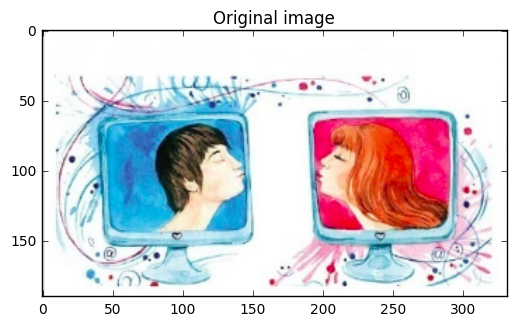

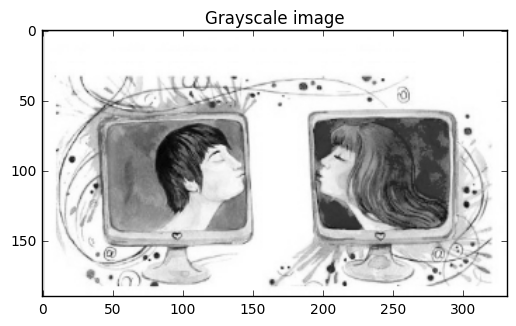

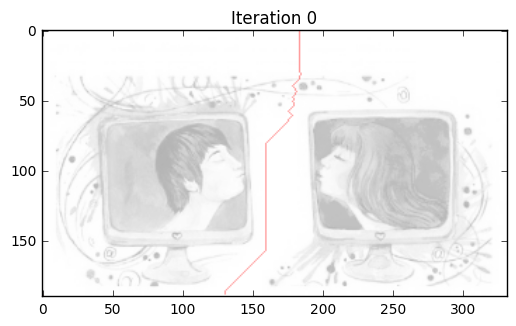

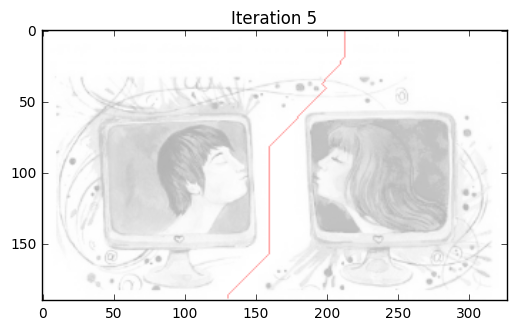

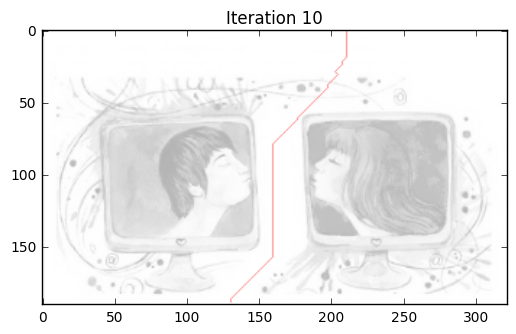

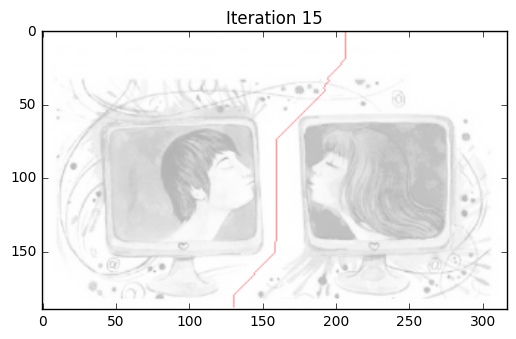

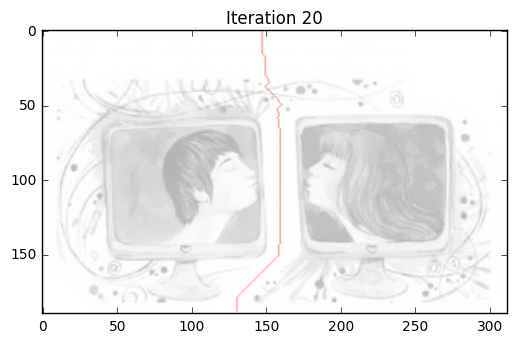

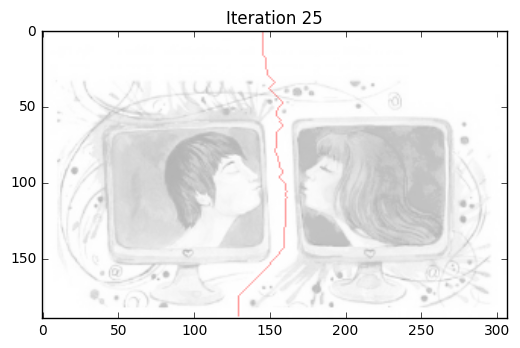

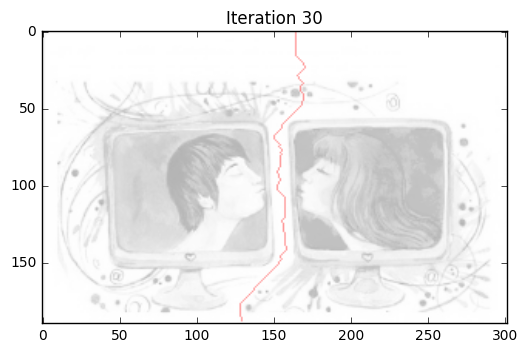

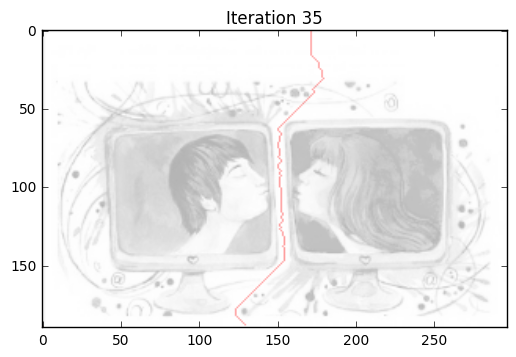

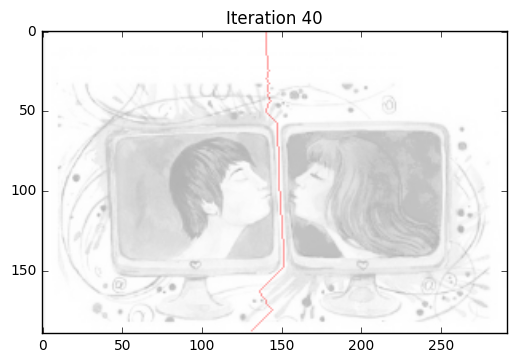

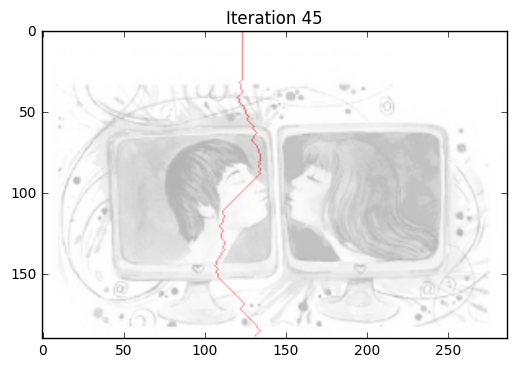

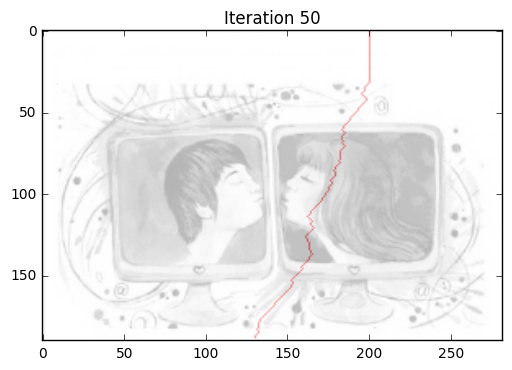

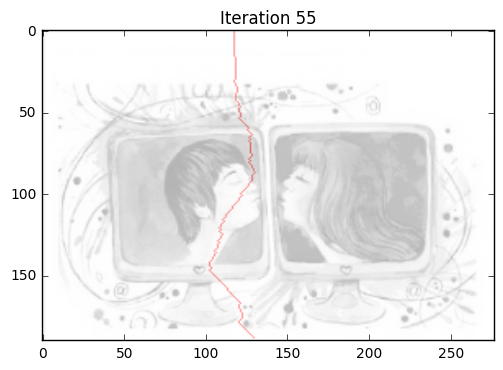

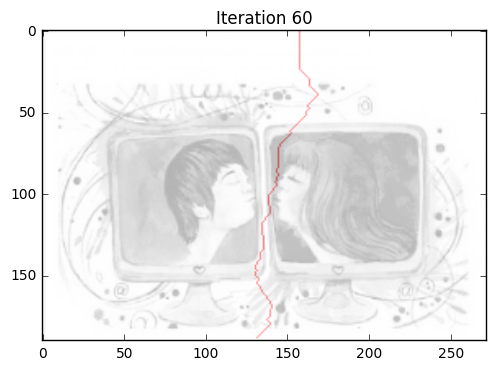

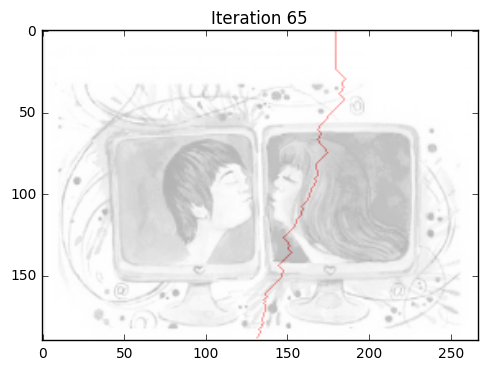

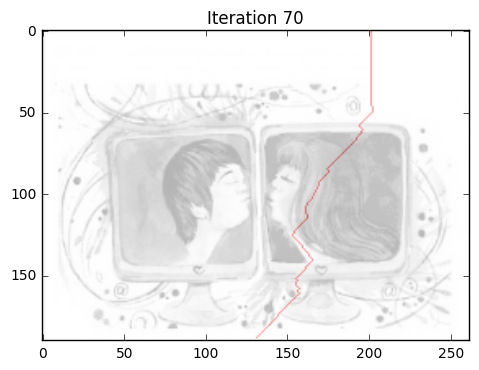

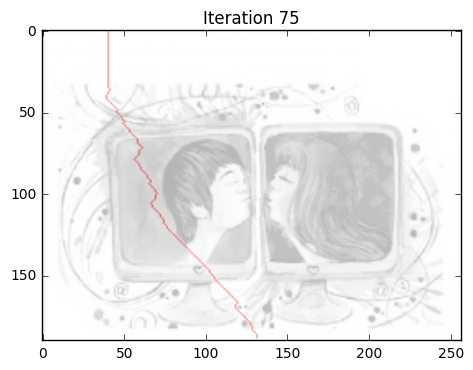

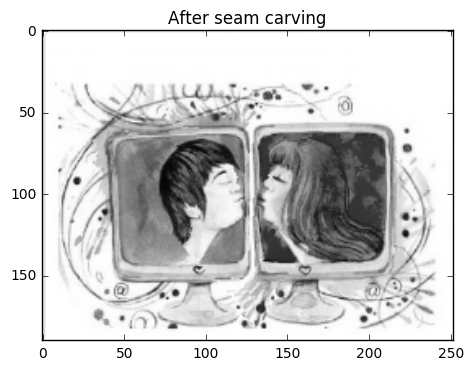

In [34]:
seam_carving("data/1.png", start_x = 130)

img has shape (77, 128, 3)


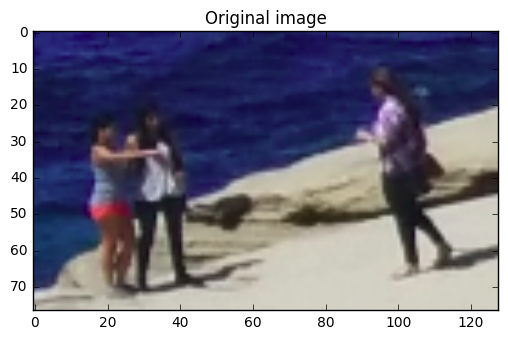

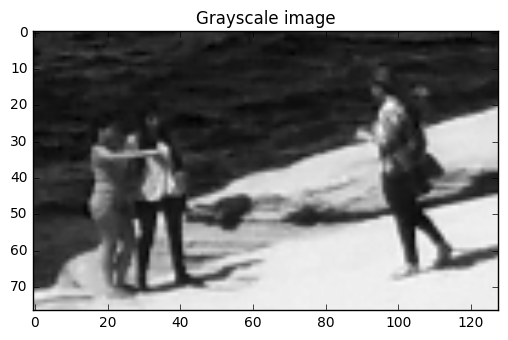

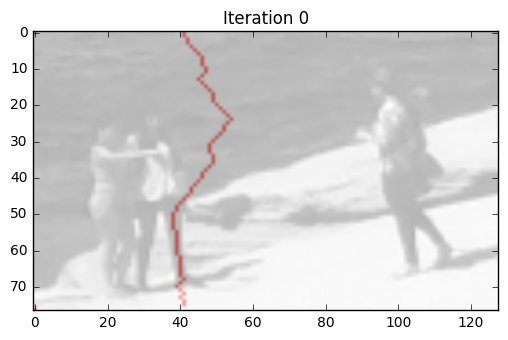

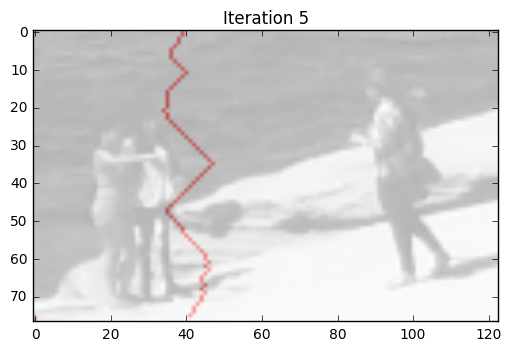

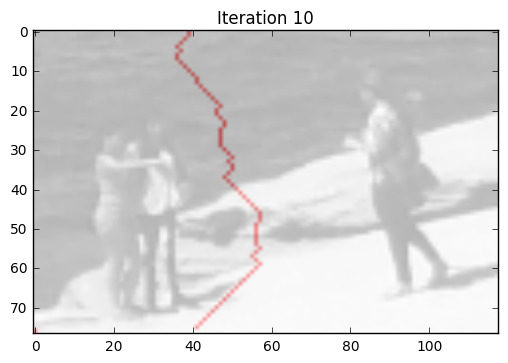

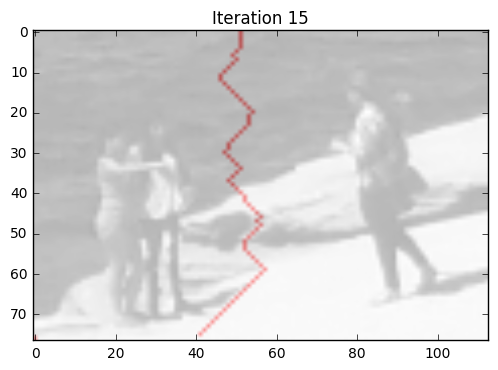

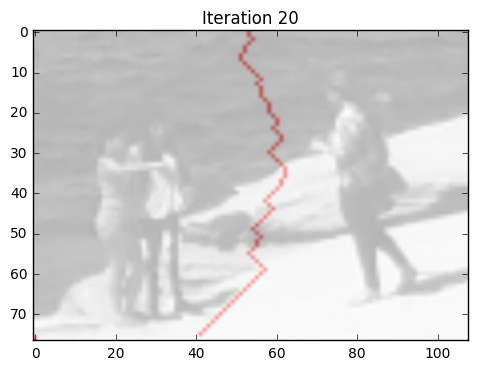

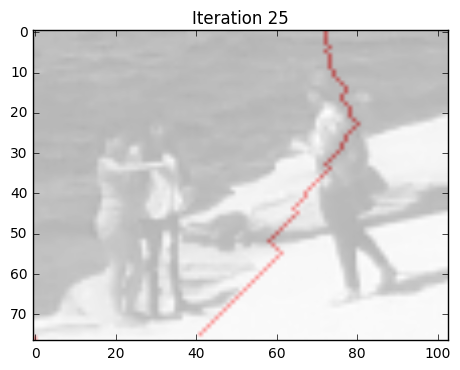

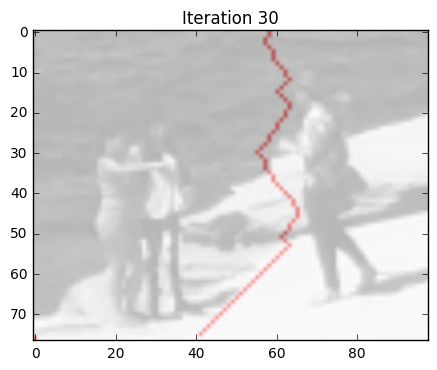

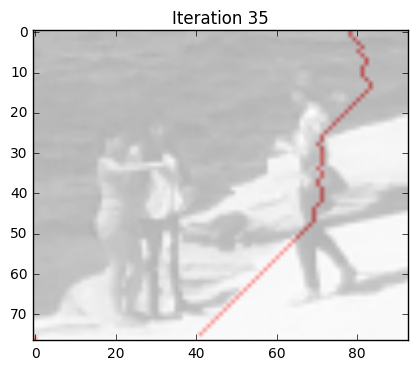

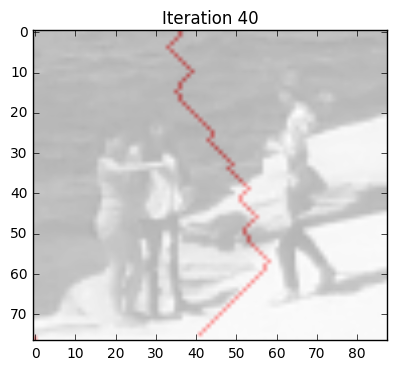

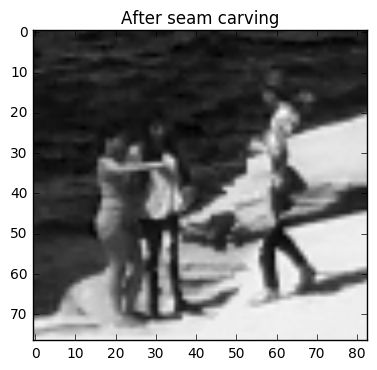

In [32]:
seam_carving("data/2.png", start_x = 40)

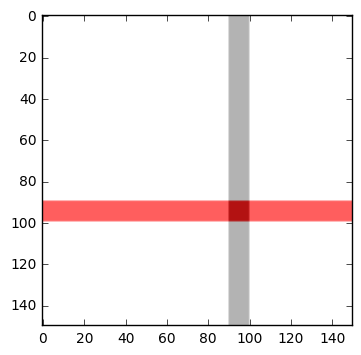

In [16]:
img = np.ones([150, 150, 3]) * 1
img[90:100, :, 1] = np.ones([10, 150]) * 0
img[90:100, :, 2] = np.ones([10, 150]) * 0
plt.figure()
plt.imshow(img, alpha=0.9) # The vertical line is down at bottom layer
'''
img = np.ones([150, 150, 3]) * 1
img[:, 90:100, 1] = np.ones([150, 10]) * 0
img[:, 90:100, 2] = np.ones([150, 10]) * 0
plt.imshow(img, alpha=0.3) # The horizontal line is at top layer
'''
img = np.ones([150, 150]) * 1
img[:, 90:100] = np.ones([150, 10]) * 0
plt.imshow(img, cmap="gray", alpha=0.3)